In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import math

In [2]:
class Gaussian:
    def __init__(self, width, amplitude, x0):
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        A = self.amplitude
        x0 = self.x0
        sigma = self.width
        return A*np.exp(-((x[0]-x0[0])**2 + (x[1]-x0[1])**2)/sigma**2)

In [3]:
class propagate:
    def __init__(self, Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.Lz = Lz
        self.Nz = Nz
        self.k = k
        self.K = K
        self.non_f = non_f
        
        #We can reduce the code by using step parameter in linspace
        
        self.dz = Lz/Nz
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.matrix = np.zeros([Nz, 2*Nx, 2*Ny])
        
        kx = 2*np.pi*np.fft.fftfreq(2*Nx, d=self.dx)
        ky = 2*np.pi*np.fft.fftfreq(2*Ny, d=self.dy)
        self.kx = kx
        self.ky = ky
        kxy2 = np.zeros([2*Nx, 2*Ny])
        
        for i in range(2*Nx):
            for j in range(2*Ny):
                kxy2[i][j] = kx[i]**2 + ky[j]**2
        self.kxy2 = kxy2
                
        self.x = np.linspace(-Lx, Lx, 2*Nx)
        self.y = np.linspace(-Ly, Ly, 2*Ny)
        E = np.zeros([2*Nx, 2*Ny])
        
        #intialisation
        for i in range(2*Nx):
            for j in range(2*Ny):
                x0 =(2*Lx)/(2*Nx-1)*i -Lx
                x1 =(2*Ly)/(2*Ny-1)*j -Ly
                #x0 =(2*Lx)/(2*Nx-1)*i
                #x1 =(2*Ly)/(2*Ny-1)*j
                E[i][j] = init_f([x0, x1])
        
        self.E = E
        self.matrix[0,:,:] = E
        
    def evolution(self):
        list_z =[]
        list_z1 = []
        E = self.E*(1+1j*0)
        list_z.append(np.abs(E)**2)
        list_z1.append(E)
        
        for l in range(Nz-1):
            '''
            #solve for non-linear
            c = np.exp(1j*self.non_f(E)*self.dz)*E
            c = np.fft.fft2(c)
            c *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(c)
            
            '''
            #Linear
            Ek = np.fft.fft2(E)
            Ek *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(Ek)
            #print(np.abs(E)/list_z[-1])
        
            #Non-linear
            #print(non_f(E)*self.dz/E)
            #if l == 0: E += non_f(E)*self.dz
            #else: E += (3/2)*non_f(list_z1[-1])*self.dz - (1/2)*non_f(list_z1[-2])*self.dz
            #E += non_f(E)*self.dz
            
            #Putting into list
            list_z.append(np.abs(E)**2)
            list_z1.append(E)
        
        list_z = np.asarray(list_z)
        list_z1 = np.asarray(list_z1)
        self.matrix = list_z
        self.matrix2 = list_z1
        

In [4]:
cross = 5.1*1e-24
light = 3*1e8
lamb = 790*1e-9
omega = 2*np.pi*light/lamb
tau = 3.5*1e-13
beta = 6.5*1e-104
hbar = 6.62*1e-34
tp = 200*1e-15
f = 1/2
n2 = 5.57*1e-23
k = 2*np.pi/lamb
K = 7

const1 = -cross/2*(1 + omega*tau)*beta/(K*hbar*omega)*tp/(8*K)**(1/2)
const2 = -beta/2
const3 = 1j*omega/light*(1-f)*n2

def non_f(E):
    const1 = -cross/2*(1 + omega*tau)*beta/(K*hbar*omega)*tp/(8*K)**(1/2)
    const2 = -beta/2
    const3 = 1j*omega/light*(1-f)*n2
    return const1*E*np.abs(E)**(2*K) + const2*E*np.abs(E)**(2*K - 2) + const3*E*np.abs(E)**2


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


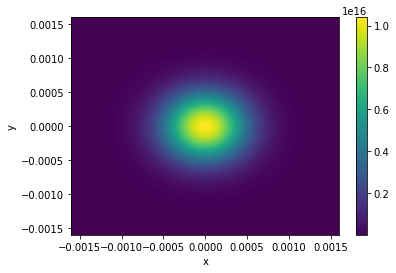

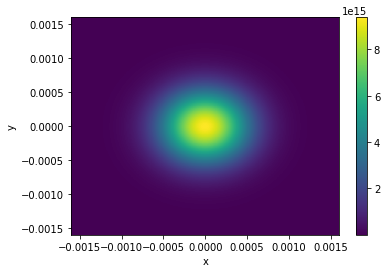

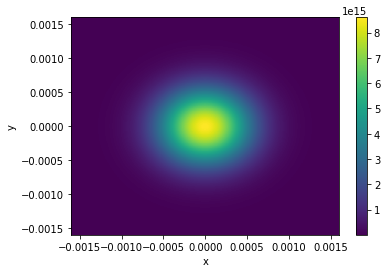

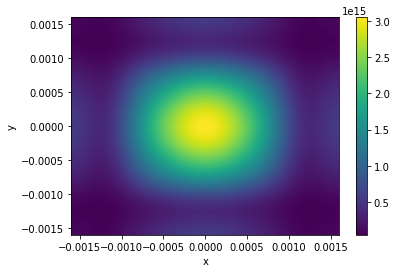

In [5]:
w0 = 0.7*1e-3
Pcr = 2*1e9
p = 4
Pin = p*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)
x0 = [0., 0.]

gauss = Gaussian(w0, AMP, x0)

Lx = 1600*1e-6
Nx = 256
Ly = 1600*1e-6
Ny = 256
Lz = 3.0
Nz = 1024

init_f = gauss

laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
laser.evolution()

#for i in range(25):
#    fig, ax = plt.subplots()
#    mesh = ax.pcolormesh(Pro.x, Pro.y, Pro.matrix[i*10])
#    ax.set_xlabel('x')
#    ax.set_ylabel('y')
#    plt.colorbar(mesh, ax=ax)
#    fig.show()

for i in [0, 219, 303, Nz-1]:
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(laser.x, laser.y, laser.matrix[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()

/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


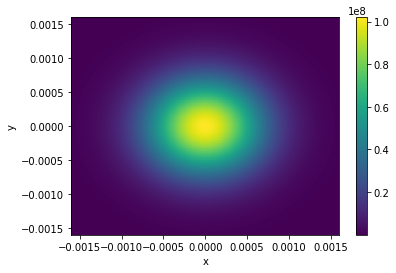

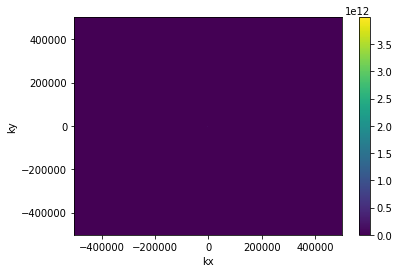

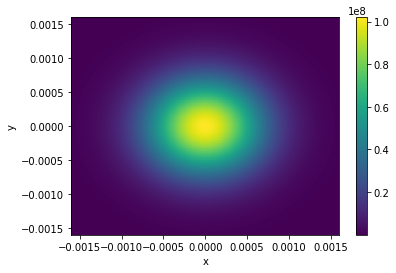

In [6]:
E = laser.matrix2[0]
fig, ax = plt.subplots()
mesh = ax.pcolormesh(laser.x, laser.y, np.abs(E))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(mesh, ax=ax)
fig.show()

#print(laser.kx)
#print(laser.ky)

Ek = np.fft.fft2(E)
fig, ax = plt.subplots()
mesh = ax.pcolormesh(laser.kx,laser.ky, np.abs(Ek))
ax.set_xlabel('kx')
ax.set_ylabel('ky')
plt.colorbar(mesh, ax=ax)
#plt.colorbar?
fig.show()

#print(Ek.real)
#print(np.mean(Ek.real))

E2 = np.fft.ifft2(Ek)
fig, ax = plt.subplots()
mesh = ax.pcolormesh(laser.x, laser.y, np.abs(E2))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(mesh, ax=ax)
fig.show()


1.835839868650398
Position: z =  0.0
Position: z =  0.6416015625
Position: z =  0.8876953125
Position: z =  2.9970703125


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


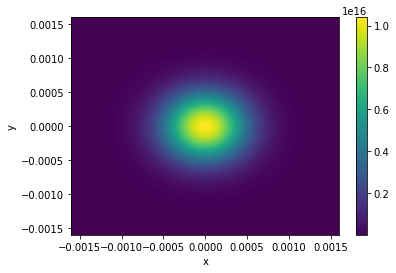

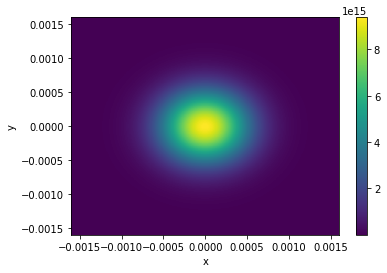

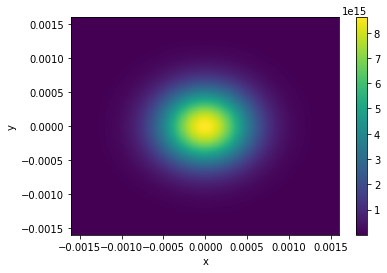

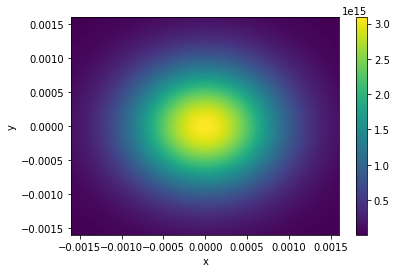

In [7]:
#Test fonction
E0 = (2*Pin/(np.pi*w0**2))**(1/2)

def w(z):
    return w0*(1 + (2*z/(k*w0**2))**2)**(1/2)

x = np.linspace(-Lx, Lx, 2*Nx)
y = np.linspace(-Ly, Ly, 2*Ny)

space_xy2 = np.zeros([2*Nx, 2*Ny])

for i in range(2*Nx):
    for j in range(2*Ny):
        space_xy2[i][j] = x[i]**2 + y[j]**2

def res_analytique(z):
    return (E0*w0/w(z)*np.exp(-space_xy2/w(z)**2))**2

print(w(Lz)/w0)

for i in [0, 219, 303, Nz-1]:
    print("Position: z = ",  i*laser.dz)
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(x, y, res_analytique(i*laser.dz))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()


Position: z =  0.0
Position: z =  0.6416015625
Position: z =  0.8876953125
Position: z =  2.9970703125


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


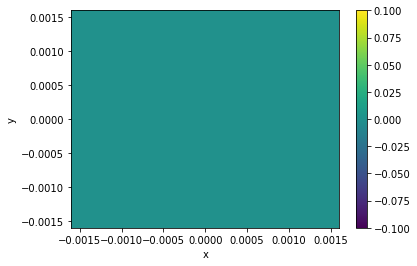

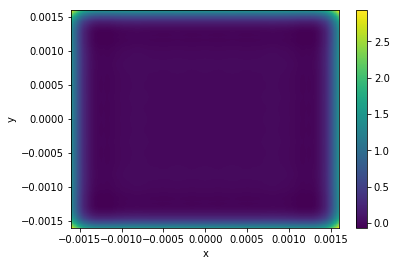

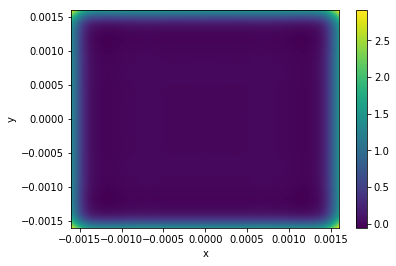

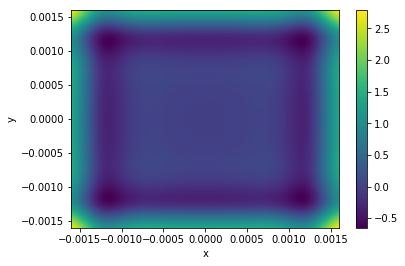

In [8]:
for i in [0, 219, 303, Nz-1]:
    print("Position: z = ",  i*laser.dz)
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(x, y, np.log(laser.matrix[i]/res_analytique(i*laser.dz)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()

262144
Position:  0.0
Mean:  0.0
Standard deviation:  0.0
------------
262144
Position:  0.6416015625
Mean:  0.161904926773
Standard deviation:  0.368013608188
------------
262144
Position:  0.8876953125
Mean:  0.175498641573
Standard deviation:  0.379404090826
------------
262144
Position:  2.9970703125
Mean:  0.163437625614
Standard deviation:  0.518738637444
------------


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


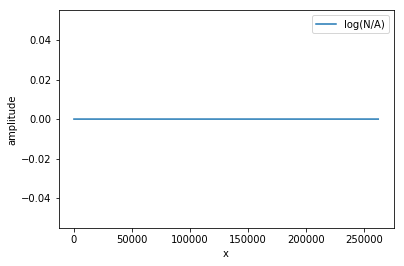

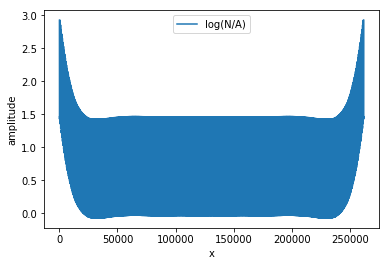

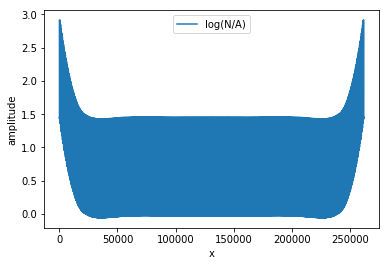

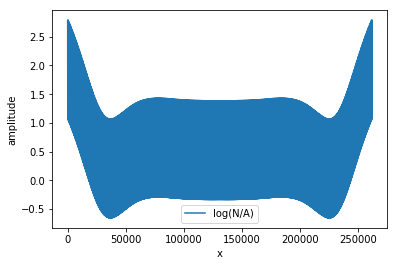

In [9]:
for i in [0, 219, 303, Nz-1]:
    A = (np.log(laser.matrix[i]/res_analytique(i*laser.dz))).flatten()
    print(A.size)
    print("Position: ", i*laser.dz)
    print("Mean: ", np.mean(A))
    print("Standard deviation: ", np.std(A))
    print("------------")
    x = np.linspace(0, 2*Nx*2*Ny, 2*Nx*2*Ny)
    fig, ax = plt.subplots()
    ax.plot(x, A, label = 'log(N/A)')
    ax.set_xlabel('x')
    ax.set_ylabel('amplitude')
    #plt.xlim(100000, 100512)
    ax.legend()
    fig.show()

262144
Position:  0.0
Mean:  0.0
Standard deviation:  0.0
------------
262144
Position:  0.6416015625
Mean:  0.161904926773
Standard deviation:  0.368013608188
------------
262144
Position:  0.8876953125
Mean:  0.175498641573
Standard deviation:  0.379404090826
------------
262144
Position:  2.9970703125
Mean:  0.163437625614
Standard deviation:  0.518738637444
------------


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


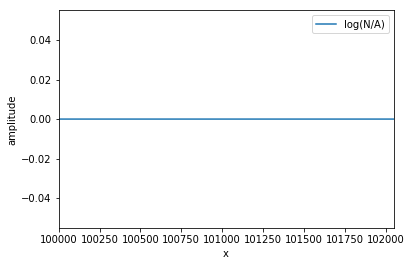

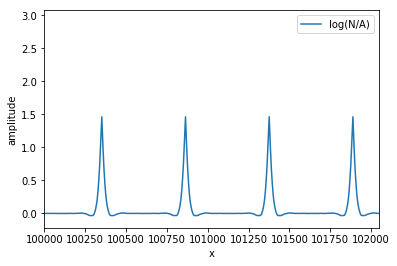

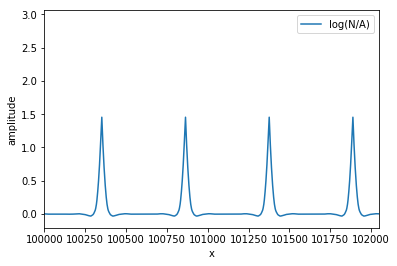

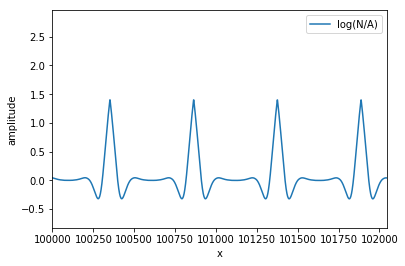

In [10]:
for i in [0, 219, 303, Nz-1]:
    A = (np.log(laser.matrix[i]/res_analytique(i*laser.dz))).flatten()
    print(A.size)
    print("Position: ", i*laser.dz)
    print("Mean: ", np.mean(A))
    print("Standard deviation: ", np.std(A))
    print("------------")
    x = np.linspace(0, 2*Nx*2*Ny, 2*Nx*2*Ny)
    fig, ax = plt.subplots()
    ax.plot(x, A, label = 'log(N/A)')
    ax.set_xlabel('x')
    ax.set_ylabel('amplitude')
    plt.xlim(100000, 102048)
    ax.legend()
    fig.show()

262144
Position:  0.0
Mean:  0.0
Standard deviation:  0.0
------------
262144
Position:  0.6416015625
Mean:  0.161904926773
Standard deviation:  0.368013608188
------------
262144
Position:  0.8876953125
Mean:  0.175498641573
Standard deviation:  0.379404090826
------------
262144
Position:  2.9970703125
Mean:  0.163437625614
Standard deviation:  0.518738637444
------------


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


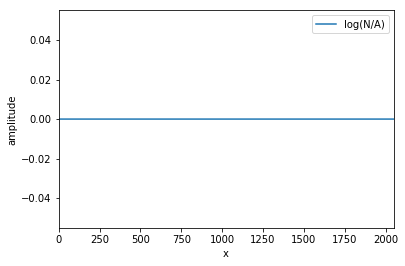

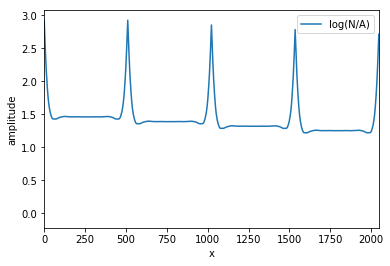

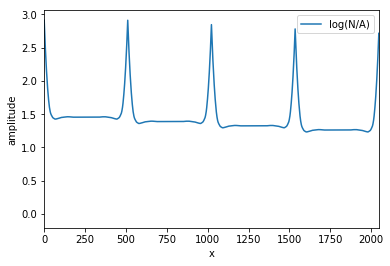

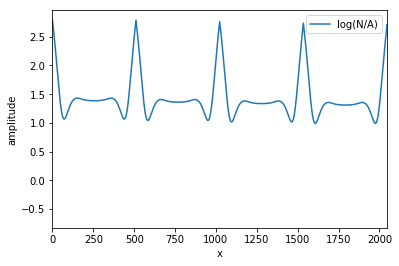

In [11]:
for i in [0, 219, 303, Nz-1]:
    A = (np.log(laser.matrix[i]/res_analytique(i*laser.dz))).flatten()
    print(A.size)
    print("Position: ", i*laser.dz)
    print("Mean: ", np.mean(A))
    print("Standard deviation: ", np.std(A))
    print("------------")
    x = np.linspace(0, 2*Nx*2*Ny, 2*Nx*2*Ny)
    fig, ax = plt.subplots()
    ax.plot(x, A, label = 'log(N/A)')
    ax.set_xlabel('x')
    ax.set_ylabel('amplitude')
    plt.xlim(0, 2048)
    ax.legend()
    fig.show()

/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


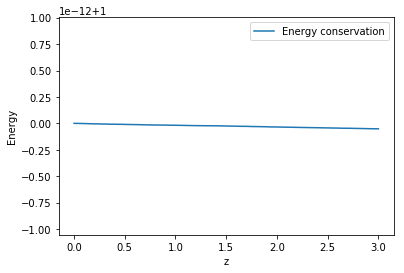

In [12]:
list_e = []
for i in range(Nz):
    E = np.sum(laser.matrix[i])
    list_e.append(E)
list_e = np.asarray(list_e)
norm = list_e[0]
x = np.linspace(0, Lz, Nz)
fig, ax = plt.subplots()
ax.plot(x, list_e/norm, label = 'Energy conservation')
ax.set_xlabel('z')
ax.set_ylabel('Energy')
ax.legend()
#plt.ylim(4.5, 5.5)
fig.show()

/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


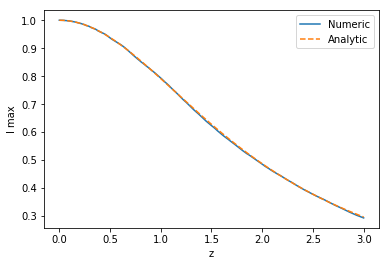

In [13]:
list_max = []

def max_analytic(z):
    return (E0*w0/w(z))**2

for i in range(Nz):
    Max = np.max(laser.matrix[i])
    list_max.append(Max)
list_max = np.asarray(list_max)
x = np.linspace(0, Lz, Nz)
fig, ax = plt.subplots()
ax.plot(x, list_max/list_max[0], label = 'Numeric')
ax.plot(x, max_analytic(x)/max_analytic(x[0]), label = 'Analytic', linestyle= 'dashed')
ax.set_xlabel('z')
ax.set_ylabel('I max')
ax.legend()
#plt.ylim(4.5, 5.5)
fig.show()